# Homework 02 Till Meineke

## Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [48]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline

## EDA

* Load the data.

In [49]:
URL = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

!wget $URL -O ./data/housing.csv

df = pd.read_csv("./data/housing.csv")
df.head(2)

--2024-09-20 12:13:41--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Auflösen des Hostnamens raw.githubusercontent.com (raw.githubusercontent.com)… 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Verbindungsaufbau zu raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 1423529 (1,4M) [text/plain]
Wird in »./data/housing.csv« gespeichert.

./data/housing.csv  100%[===================>]   1,36M  5,81MB/s    in 0,2s    

2024-09-20 12:13:42 (5,81 MB/s) - »./data/housing.csv« gespeichert [1423529/1423529]



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


* Look at the `median_house_value` variable. Does it have a long tail?

In [51]:
df.median_house_value.max()

500001.0

In [52]:
df.median_house_value.value_counts().sort_values(ascending=False)

median_house_value
500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
387300.0      1
387400.0      1
387900.0      1
388200.0      1
357500.0      1
Name: count, Length: 3842, dtype: int64

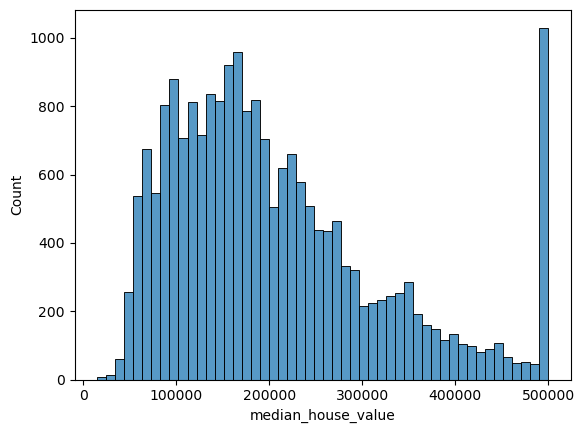

In [101]:
sns.histplot(df.median_house_value, bins=50);  # [df.median_house_value < 100_000]

There seems to be a long tail in the `median_house_value` variable, but for values = 500001.0, which is the maximum value in the dataset, there are 965 instances. Maybe this is a cap value, and the values above 500000.0 are capped to 500001.0.

## Preparing the dataset

For this homework, we only want to use a subset of data.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

In [54]:
df.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [55]:
# keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`
df_filtered = df[df.ocean_proximity.isin(["<1H OCEAN", "INLAND"])]

In [56]:
df_filtered.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64

Next, use only the following columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

In [57]:
columns = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value",
]

df_filtered = df_filtered[columns]

In [58]:
df_filtered.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0


## Question 1

There's one feature with missing values. What is it?

In [59]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [60]:
df_filtered.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [61]:
print("Total bedrooms missing values: ", df_filtered.total_bedrooms.isnull().sum())

Total bedrooms missing values:  157


In [62]:
# Which column has missing values?
print(
    "Columns with missing values: ",
    df_filtered.columns[df_filtered.isnull().any()].tolist()[0],
)

Columns with missing values:  total_bedrooms


## Question 2

What's the median (50% percentile) for variable `'population'`?

In [63]:
print(
    "The median (50% percentile) for variable 'population' is: ",
    df_filtered["population"].median(),
)

The median (50% percentile) for variable 'population' is:  1195.0


## Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.

In [64]:
# from sklearn.utils import shuffle

# seed = 42

# # shuffle dataset
# df_filtered = shuffle(df_filtered, random_state=seed)

In [65]:
n = len(df_filtered)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df_filtered.iloc[idx]

* Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [66]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val :].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [67]:
# from sklearn.model_selection import train_test_split

# df_full_train, df_test = train_test_split(df_filtered, test_size=0.2, random_state=seed)

In [68]:
# len(df_full_train), len(df_test)

In [69]:
# df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

In [70]:
# len(df_train), len(df_val), len(df_test)

* Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.

In [71]:
# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

# y_train = df_train.median_house_value.values
# y_val = df_val.median_house_value.values
# y_test = df_test.median_house_value.values

# del df_train["median_house_value"]
# del df_val["median_house_value"]
# del df_test["median_house_value"]

In [72]:
# y_train = np.log1p(y_train)
# y_val = np.log1p(y_val)
# y_test = np.log1p(y_test)

In [73]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

## Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!

In [74]:
mean_tb = df_train.total_bedrooms.mean()
mean_tb

542.552956325786

In [75]:
# fill missing values in `total_bedrooms` with the median value
X_train_mean = df_train.fillna(mean_tb).values
X_val_mean = df_val.fillna(mean_tb).values
X_test_mean = df_test.fillna(mean_tb).values

In [76]:
# fill missing values in `total_bedrooms` with 0
X_train_zero = df_train.fillna(0).values
X_val_zero = df_val.fillna(0).values
X_test_zero = df_test.fillna(0).values

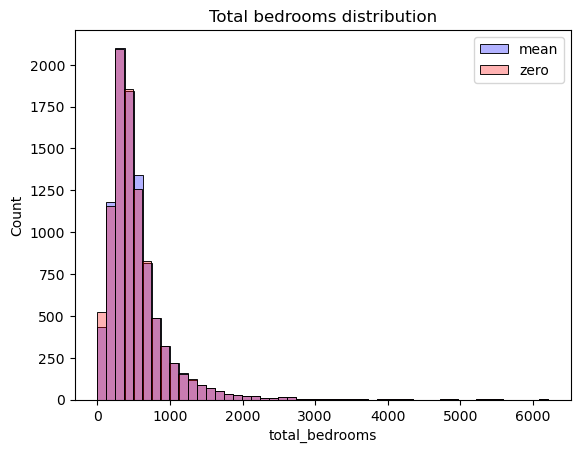

In [111]:
import seaborn as sns
sns.histplot(df_train.total_bedrooms.fillna(mean_tb), bins=50, color="blue", alpha=0.3, label="mean")
sns.histplot(df_train.total_bedrooms.fillna(0), bins=50, color="red", alpha=0.3, label="zero")
plt.legend()
plt.title("Total bedrooms distribution")
plt.show();

In [79]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [80]:
# Evaluate models
def rmse(y, y_pred):
    error = y - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [81]:
w0_median, w_median = train_linear_regression(X_train_mean, y_train)
y_pred_median = w0_median + X_val_mean.dot(w_median)

In [82]:
w0_zero, w_zero = train_linear_regression(X_train_zero, y_train)
y_pred_zero = w0_zero + X_val_zero.dot(w_zero)

* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [83]:
print("RMSE for model with median filled values: ", rmse(y_val, y_pred_median).round(2))
print("RMSE for model with 0 filled values: ", rmse(y_val, y_pred_zero).round(2))

RMSE for model with median filled values:  0.34
RMSE for model with 0 filled values:  0.34


- Both are equally good

## Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

In [84]:
def prepare_X(df):
    df = df.copy()
    df = df.fillna(0)

    X = df.values
    return X

In [85]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [86]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
for r in [0.0, 0.000001, 0.0001, 0.001,0.01, 0.1, 1,5, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    print("r: %06s - rmse: %0.5f" % (r, score))

r:    0.0 - rmse: 0.34085
r:  1e-06 - rmse: 0.34085
r: 0.0001 - rmse: 0.34085
r:  0.001 - rmse: 0.34085
r:   0.01 - rmse: 0.34088
r:    0.1 - rmse: 0.34129
r:      1 - rmse: 0.34490
r:      5 - rmse: 0.34774
r:     10 - rmse: 0.34831


0.0 - 0.001 gives lowest RMSE with 0.34085, but if we round the RMSE to 2 decimal digits, 0 needs to be selected, because it is the smallest `r` value.

## Question 5

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

In [87]:
def prepare_X(df, fillna_value):
    df = df.fillna(fillna_value)
    X = df.values
    return X

In [88]:
rmses = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    n = len(df_filtered)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_shuffled = df_filtered.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val :].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)

    del df_train["median_house_value"]
    del df_val["median_house_value"]
    del df_test["median_house_value"]

    X_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w_0 + X_val.dot(w)

    result = rmse(y_val, y_pred)

    rmses.append(result)
    print(s, result)


0 0.3377387160079039
1 0.3377999353666329
2 0.3384287006762634
3 0.33200494683062565
4 0.33944518625553566
5 0.3433819705285435
6 0.3385330211765444
7 0.3468747697287077
8 0.35127368659605346
9 0.33415582665137267


* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

In [89]:
print("The value of std is: ", np.std(rmses).round(3))

The value of std is:  0.005


## Question 6

* Split the dataset like previously, use seed 9.

In [91]:
n = len(df_filtered)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_shuffled = df_filtered.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val :].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

* Combine train and validation datasets.

In [92]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

* Fill the missing values with 0 and train a model with `r=0.001`.

In [93]:
X_full_train = prepare_X(df_full_train, fillna_value=0)
y_full_train = np.concatenate([y_train, y_val])

w_0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

* What's the RMSE on the test dataset?

In [99]:
X_test = prepare_X(df_test, fillna_value=0)
y_pred = w_0 + X_test.dot(w)

result = rmse(y_test, y_pred)

print(f"The RMSE for the model is: ", result.round(2))

The RMSE for the model is:  0.33
